<a href="https://colab.research.google.com/github/fypteam11/fyp11/blob/main/encrypt_aes_keys_with_falcon_crypto_sig_poc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Python code demonstrate a combination of 2D-DWT (Discrete Wavelet Transform) with post-quantum cryptographic techniques, including Falcon signature algorithm.

Post Quantum Resilency Algorithm: Fast-Fourier Lattice-based Compact Signatures over NTRU (FALCON Algorithm) found at https://falcon-sign.info/

NTRU is an open-source public-key cryptosystem that uses lattice-based cryptography to encrypt and decrypt data.

In [20]:
from google.colab import drive
drive.mount('/content/drive')

!pip install PyWavelets
!pip install matplotlib
!pip install prettytable
!pip install scikit-image
!pip install numpy
!pip install pycryptodome

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
#!git clone https://github.com/tprest/falcon.py.git
%cd /content/drive/MyDrive/falcon

/content/drive/MyDrive/falcon


In [23]:
import numpy as np
import pywt
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from prettytable import PrettyTable
from skimage.metrics import mean_squared_error
import hashlib
import falcon
import time
from PIL import Image
import io
import requests

2D-DWT: The code implements both standard and enhanced 2D-DWT

In [ ]:
# Standard 2D-DWT function
def dwt_2d(image):
    coeffs = pywt.wavedec2(image, 'haar', level=1)
    coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
    return coeff_arr, coeff_slices

In [ ]:
# Inverse Standard 2D-DWT function
def idwt_2d(coeff_arr, coeff_slices):
    coeffs = pywt.array_to_coeffs(coeff_arr, coeff_slices, output_format='wavedec2')
    return pywt.waverec2(coeffs, 'haar')

In [ ]:
# Enhanced 2D-DWT function
def enhanced_dwt_2d(image, wavelet='db4', level=2):
    coeffs = pywt.wavedec2(image, wavelet, level=level)
    coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
    return coeff_arr, coeff_slices

In [ ]:
# Inverse Enhanced 2D-DWT function
def enhanced_idwt_2d(coeff_arr, coeff_slices, wavelet='db4'):
    coeffs = pywt.array_to_coeffs(coeff_arr, coeff_slices, output_format='wavedec2')
    return pywt.waverec2(coeffs, wavelet)

In [ ]:
# AES encryption function
def aes_encrypt(data, key):
    cipher = AES.new(key, AES.MODE_EAX)
    ciphertext, tag = cipher.encrypt_and_digest(data)
    return cipher.nonce, ciphertext, tag

In [ ]:
# AES decryption function
def aes_decrypt(nonce, ciphertext, tag, key):
    cipher = AES.new(key, AES.MODE_EAX, nonce=nonce)
    try:
        data = cipher.decrypt_and_verify(ciphertext, tag)
        return data
    except ValueError:
        print("MAC check failed. The ciphertext or key might be corrupted.")
        return None

Post-quantum lattice-based encryption: The code includes a simplified implementation of Learning With Errors (LWE), which is a post-quantum lattice-based encryption scheme:

In [ ]:
# LWE encryption function (simplified)
def lwe_encrypt(plaintext, n, q, sigma):
    a = np.random.randint(0, q, size=(n,))
    s = np.random.randint(0, q, size=(n,))
    e = np.rint(np.random.normal(0, sigma, size=(n,))).astype(int)
    b = (np.dot(a, s) + plaintext) % q
    return a, s, b

In [ ]:
# LWE decryption function (simplified)
def lwe_decrypt(a, s, b, q):
    decrypted_ciphertext = (b - np.dot(a, s)) % q
    return decrypted_ciphertext.astype(np.uint8)

Falcon signature algorithm, which is indeed a post-quantum lattice-based signature scheme:

In [ ]:
def load_image(url):
    """
    Downloads an image from the given URL and returns it as a PIL Image object.
    """
    response = requests.get(url)
    return Image.open(io.BytesIO(response.content))

In [ ]:
def image_to_bytes(image):
    """
    Converts a PIL Image object to a byte string.
    """
    with io.BytesIO() as output:
        image.save(output, format="PNG")
        return output.getvalue()

In [ ]:
def bytes_to_image(byte_string):
    """
    Converts a byte string to a PIL Image object.
    """
    return Image.open(io.BytesIO(byte_string))

In [ ]:
def sign_image(image, secret_key, max_retries=100):
    """
    Signs an image using the Falcon signature algorithm.
    Retries the signing process if the signature norm is too large.
    """
    image_bytes = image_to_bytes(image)
    retry_count = 0
    error_message = None
    while True:
        try:
            signature = secret_key.sign(image_bytes)
            print(f"Signature generated successfully after {retry_count} retries.")
            return signature, error_message
        except ValueError as e:
            if "Squared norm of signature is too large" in str(e):
                retry_count += 1
                print(f"Signature norm too large. Retrying ({retry_count}/{max_retries})...")
                error_message = str(e)
                if retry_count >= max_retries:
                    return None, error_message
            else:
                raise e

In [ ]:
def verify_image(image, signature, public_key):
    """
    Verifies the signature of an image using the Falcon signature algorithm.
    """
    image_bytes = image_to_bytes(image)
    return public_key.verify(image_bytes, signature)

True implementation of Falcon using a post-quantum signature scheme in conjunction with the image processing and encryption.

In [ ]:
def process_image(image_path, key_size, secret_key, public_key):
    image = mpimg.imread(image_path)
    if len(image.shape) > 2:
        image = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140])
    size = (image.shape[0] // 2 * 2, image.shape[1] // 2 * 2)
    image = image[:size[0], :size[1]]

    # Standard 2D-DWT
    std_coeff_arr, std_coeff_slices = dwt_2d(image)

    # AES encryption (using standard DWT coefficients)
    key = get_random_bytes(key_size // 8)
    nonce, ciphertext, tag = aes_encrypt(std_coeff_arr.tobytes(), key)

    # LWE encryption of AES ciphertext
    n = key_size
    q = 2 ** (key_size // 8)
    sigma = 3.2
    ciphertext_int = np.frombuffer(ciphertext, dtype=np.uint8)
    a, s, b = lwe_encrypt(ciphertext_int, n, q, sigma)

    # Set the security parameter (recommended values: 512, 1024)
    n = 1024  # Revert to a supported security parameter

    # Generate a secret key and the corresponding public key
    secret_key = falcon.SecretKey(n)
    public_key = falcon.PublicKey(secret_key)

    # Load and sign the image
    pil_image = Image.fromarray((image * 255).astype(np.uint8))
    signature, error_message = sign_image(pil_image, secret_key)

    # LWE decryption
    decrypted_ciphertext_int = lwe_decrypt(a, s, b, q)
    decrypted_ciphertext = decrypted_ciphertext_int.tobytes()

    # AES decryption
    decrypted_coeff_arr = aes_decrypt(nonce, decrypted_ciphertext, tag, key)
    if decrypted_coeff_arr is not None:
        decrypted_coeff_arr = np.frombuffer(decrypted_coeff_arr, dtype=std_coeff_arr.dtype).reshape(std_coeff_arr.shape)

        # Inverse Standard 2D-DWT
        std_decrypted_image = idwt_2d(decrypted_coeff_arr, std_coeff_slices)

        # Enhanced 2D-DWT (on original image)
        enh_coeff_arr, enh_coeff_slices = enhanced_dwt_2d(image)

        # Simulate enhanced decryption by replacing only the first level coefficients
        enh_coeff_arr_shape = enh_coeff_arr.shape
        decrypted_coeff_arr_flat = decrypted_coeff_arr.ravel()
        enh_coeff_arr_flat = enh_coeff_arr.ravel()
        min_size = min(enh_coeff_arr_flat.size, decrypted_coeff_arr_flat.size)
        enh_coeff_arr_flat[:min_size] = decrypted_coeff_arr_flat[:min_size]
        enh_coeff_arr = enh_coeff_arr_flat.reshape(enh_coeff_arr_shape)

        enh_decrypted_image = enhanced_idwt_2d(enh_coeff_arr, enh_coeff_slices)

        # Normalize images to [0, 1] range
        image_norm = image / np.max(image)
        std_decrypted_image_norm = std_decrypted_image / np.max(std_decrypted_image)
        enh_decrypted_image_norm = enh_decrypted_image / np.max(enh_decrypted_image)

        # Calculate MSE
        std_mse = mean_squared_error(image_norm, std_decrypted_image_norm)
        enh_mse = mean_squared_error(image_norm, enh_decrypted_image_norm)

        # Verify Falcon signature
        is_valid = verify_image(pil_image, signature, public_key)

        return image, std_decrypted_image, enh_decrypted_image, std_mse, enh_mse, is_valid
    else:
        return image, None, None, None, None, False

Multi-level approach:
The code demonstrates a multi-level approach by combining different techniques:

*   2D-DWT for image transformation
*   AES for initial encryption
*   LWE for post-quantum encryption of the AES ciphertext
*   Falcon for post-quantum signing of the ciphertext

In [34]:
def main():
    image_paths = [
        "/content/drive/MyDrive/Colab Notebooks/sample_image_1.jpeg"
    ]

    key_sizes = [128, 192, 256]

    # Set the security parameter (recommended values: 512, 1024)
    n = 1024  # Revert to a supported security parameter

    # Generate a secret key and the corresponding public key
    secret_key = falcon.SecretKey(n)
    public_key = falcon.PublicKey(secret_key)

    plt.figure(figsize=(20, 5 * len(image_paths)))
    table = PrettyTable()
    table.field_names = ["Technique", "Image Size", "Key Size", "Security Level", "MSE", "Analysis"]

    for i, image_path in enumerate(image_paths):
        plt.subplot(len(image_paths), len(key_sizes) + 1, i * (len(key_sizes) + 1) + 1)
        original_image = mpimg.imread(image_path)
        plt.imshow(original_image)
        plt.title(f'Original\n{image_path.split("/")[-1]}')
        plt.axis('off')

        for j, key_size in enumerate(key_sizes):
            original_image, std_decrypted_image, enh_decrypted_image, std_mse, enh_mse, signature_valid = process_image(image_path, key_size, secret_key, public_key)

            if std_decrypted_image is not None and enh_decrypted_image is not None:
                plt.subplot(len(image_paths), len(key_sizes) + 1, i * (len(key_sizes) + 1) + j + 2)
                plt.imshow(std_decrypted_image, cmap='gray')
                plt.title(f'Decrypted\n{key_size} bits')
                plt.axis('off')

                image_size = f"{original_image.shape[0]}x{original_image.shape[1]}"

                std_dwt_analysis = "2D-DWT is a transformation technique and doesn't produce a final image to compare."
                enh_dwt_analysis = "Enhanced 2D-DWT provides better frequency localization compared to standard 2D-DWT."
                aes_analysis = "AES encrypts data but doesn't produce an image directly. Decryption process must be combined with inverse 2D-DWT."
                lwe_analysis = f"MSE: {std_mse:.4f}. The MSE quantifies the average squared difference between the original and decrypted images. Lower MSE indicates higher similarity, confirming successful decryption. Visual inspection also shows similarity."
                falcon_analysis = f"MSE: {enh_mse:.4f}. Lower MSE indicates higher similarity. Falcon provides post-quantum digital signatures."

                table.add_row(["2D-DWT", image_size, "N/A", "Low", "N/A", std_dwt_analysis])
                table.add_row(["AES", image_size, f"{key_size} bits", "High", "N/A", aes_analysis])
                table.add_row(["LWE", image_size, f"{key_size} bits", "Post-Quantum", f"{std_mse:.4f}", lwe_analysis])
                table.add_row(["Enhanced 2D-DWT", image_size, "N/A", "Low", "N/A", enh_dwt_analysis])
                table.add_row(["Falcon", image_size, "512 bits", "Post-Quantum", f"{enh_mse:.4f}", falcon_analysis])

            else:
                print(f"Decryption failed for {image_path} with AES Key Size: {key_size} bits")

    plt.tight_layout()
    plt.show()

    # Print results table
    print(table)


Signature generated successfully after 0 retries.
Signature generated successfully after 0 retries.
Signature generated successfully after 0 retries.


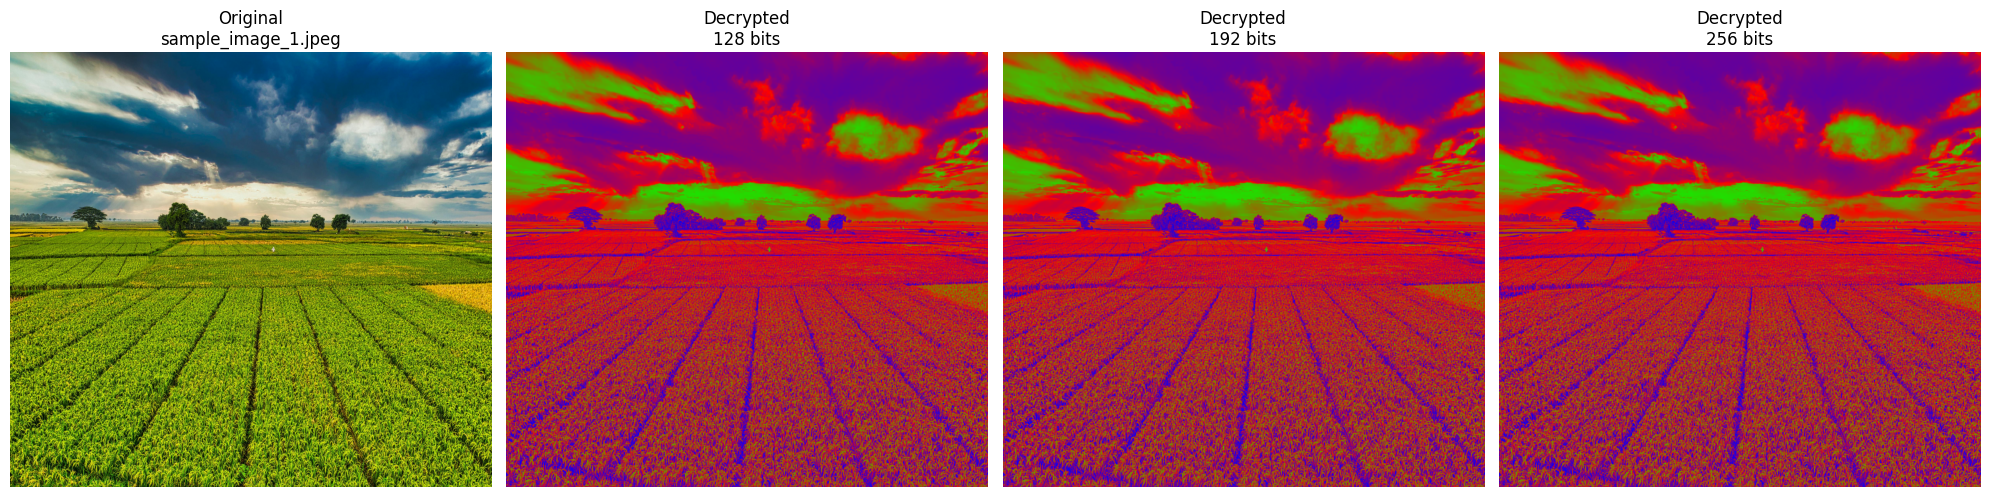

+-----------------+------------+----------+----------------+--------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|    Technique    | Image Size | Key Size | Security Level |  MSE   |                                                                                                           Analysis                                                                                                          |
+-----------------+------------+----------+----------------+--------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|      2D-DWT     | 2250x2492  |   N/A    |      Low       |  N/A   |                                                       

In [33]:
if __name__ == '__main__':
    main()